# The Chebyshev Pseudospectral Method for Boundary Value Problems

Consider the second order linear differential equation:

$$ \frac{d}{dx}\left( \alpha(x) \frac{du}{dx} \right) + \beta(x) \frac{du}{dx} + \gamma(x) u(x) = f(x), \qquad x\in[a, b]$$

Here $\alpha, \beta, \gamma$ and $f$ are all continuous functions and $\alpha$ is strictly positive.
Subject to the Dirichlet boundary conditions:

$$u(a) = u_a \qquad u(b) = u_b.$$

We will approximate $u$ by the interpolating polynomials:

$$u(x) \approx \sum_{k=0}^N u(x_k) C_k(x).$$

Here $x_k$ are the Chebyshev-Lobatto grid points which are given in the reference interval $[-1,1]$,

$$x_k = -\cos\left( \frac{k \pi}{N} \right), \qquad i=0, \dots, N,$$

and $C_k(x)$ are the Lagrange interpolating polynomials associated with this grid which are formally defined by

$$C_k(x) = \prod_{j=0,j\neq k}^N \frac{x-x_j}{x_k-x_j}.$$

Let $u_k := u(x_k)$ which we collect in a vector $\vec{u} = \begin{pmatrix} u_0 & u_1 & \cdots & u_N \end{pmatrix}^T.$

Recall the differentiation matrix $\mathcal{D}$ which maps $u(x_k)$ to $u'(x_k)$ via:

$$ u'(x_k) \approx (\mathcal{D} \vec{u})_k.$$

We can construct the pseudospectral method by replacing $u$ with $\vec{u}$ and $\frac{d}{dx}$ with $\mathcal{D}$ in the differential equation to get

$$ \mathcal{D}\left(A \mathcal{D}\vec{u} \right) + B \mathcal{D}\vec{u} + C\vec{u} = \vec{f}. $$

Here, $A, B,$ and $C$ are diagonal matrices whose elements are given by:

$$A_{kk} = \alpha(x_k), \quad B_{kk} = \beta(x_k), \quad C_{kk} = \gamma(x_k).$$

Similarly, $f_k = f(x_k)$. The solution $\vec{u}$ is, therefore, the solution to the linear system:

$$ \mathcal{L} \vec{u} = \vec{f}, $$

where

$$ \mathcal{L} = \mathcal{D}A\mathcal{D} + B\mathcal{D} + C. $$

It can be verified that $\mathcal{L}$ is __not__ invertible. The reason is that the we have yet to enforce the boundary conditions. Define $I$ to be the $N+1 \times N+1$ identity matrix, and denote by $\mathbf{e}_k$ to be the $k$-th column of $I$. Define $P$ to be the $N+1 \times N-1$ matrix whose columns are $\mathbf{e}_1, \mathbf{e}_2, \dots, \mathbf{e}_{N-1}$ i.e. all of the columns of $I$ excluding the first one, $\mathbf{e}_0$, and the last one $\mathbf{e}_N$. Let $\mathbf{u}\in\R^{N-1}$ be the interior values of $\vec{u}$, i.e.
$$\mathbf{u} = \begin{pmatrix} u_1 \\ u_2 \\ \vdots \\ u_{N-1} \end{pmatrix} = P^T \vec{u}$$
Define the splitting
$$\vec{u} = P \mathbf{u} + u_a \mathbf{e}_0 + u_b \mathbf{e}_N.$$
We substitute this splitting into $\mathcal{L}\vec{u} = \vec{f}$ and multiply both sides by $P^T$ to get a linear system for the interior values $\mathbf{u}$,
$$P^T\mathcal{L}\left( P \mathbf{u} + u_a \mathbf{e}_0 + u_b \mathbf{e}_N \right) = P^T\vec{f}.$$
$$P^T \mathcal{L} P \mathbf{u} = P^T \vec{f} - u_a P^T\mathcal{L}\mathbf{e}_0 - u_b P^T\mathcal{L}\mathbf{e}_N.$$
Let $\mathbf{L} = P^T \mathcal{L} P$ and $\mathbf{b} = P^T \vec{f} - P^T\mathcal{L}\mathbf{e}_0 - P^T\mathcal{L}\mathbf{e}_N$, then
$$\mathbf{L u} = \mathbf{b}.$$

Now, $\mathbf{L}$ is invertible, and we can solve this linear system for $\mathbf{u}$ which allows us to conclude:
$$\vec{u} = P \mathbf{L}^{-1}\mathbf{b} + u_a \mathbf{e}_0 + u_b \mathbf{e}_N.$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from numpy.linalg import solve
from cheb import * # Here is some useful code from `interpolation.ipynb`

Consider the example problem on $[-1, 1]$:

$$ \alpha(x) = 1 + \frac{1}{2} \sin(6\pi x), \quad \beta(x) = 0, \quad \gamma(x) = 64(1-x^2), \quad f(x) = \frac{20}{\sqrt{\pi}} e^{-(20x)^2}. $$

with boundary conditions:

$$u_a = 1, \quad u_b = 0.$$

In [2]:
# problem set up

alpha = lambda x: 1 + 0.5 * np.sin(6 * np.pi * x)
beta  = lambda x: np.zeros_like(x)
gamma = lambda x: 64 * (1 - x**2)

m = 20 / np.sqrt(np.pi)
f = lambda x: m * np.exp( -(20*x)**2 )

ua = 1
ub = 0

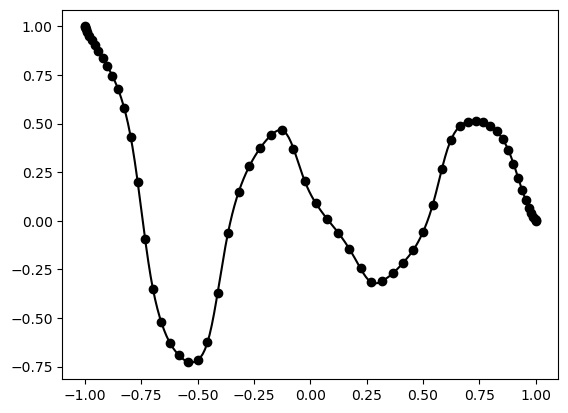

In [3]:
# setup Chebyshev grid and differentiation matrix
N = 64
x = chebyshev_lobatto_grid(-1, 1, N)
D = diff_matrix(x)

# set up variable coefficients
A = np.diag( alpha(x) )
B = np.diag( beta(x) )
C = np.diag( gamma(x) )

# construct descrete differential operator
L = D @ A @ D + B @ D + C

# construct partition
I = np.eye(N)
e0 = I[:,  0]
eN = I[:, -1]
P = I[:, 1:-1]

# eliminate boundary conditions
q0 = P.T @ (L @ e0)
qN = P.T @ (L @ eN)

b = P.T @ f(x) - ua * q0 - ub * qN
L = P.T @ L @ P

# solve differential equation
u = P @ solve(L, b) + ua * e0 + ub * eN

# evaluate solution and plot
t = np.linspace(-1, 1, 200)
P = interpolation_matrix(x, t)

plt.plot(t, P @ u, '-k')
plt.plot(x, u, 'ok')
plt.show()

# Neumann Boundary Conditions

Consider the same differential equation but we replace the Dirichlet condition at $x = a$ with the Neumann boundary condition:
$$u'(a) = u_a.$$
For the most part, the differential equation stays unchanged, so we still work with
$$\mathcal{L} \vec{u} = \vec{f}, \qquad \mathcal{L} = \mathcal{D}A\mathcal{D} + B\mathcal{D} + C.$$
Unlike in the case of the Dirichlet boundary condition we cannot simply eliminate $u_0$. Instead, we identify where in the linear system the boundary condition can be enforced.
First, note that if $\vec{u}$ is the approximate solution to the differential equation, then
$$(\mathcal{D}\vec{u})_0 = u_a.$$
This implies the partition
$$\mathcal{D}\vec{u} = u_a \mathbf{e}_0 + (I - \mathbf{e}_0\mathbf{e}_0^T)\mathcal{D} \vec{u}.$$
Let $\hat{\mathcal{D}} = (I - \mathbf{e}_0\mathbf{e}_0^T)\mathcal{D}$, then $\mathcal{D}\vec{u} = u_a \mathbf{e}_0 + \hat{\mathcal{D}}\vec{u}$.
We substitute this partition into $\mathcal{L} \vec{u} = \vec{f}$ to get:
$$\mathcal{D}\left[A \left(u_a \mathbf{e}_0 + \hat{\mathcal{D}} \vec{u} \right) \right] + B\left(u_a \mathbf{e}_0 + \hat{\mathcal{D}} \vec{u} \right) + C \vec{u} = \vec{f}.$$
Rearanging this equation we get:

$$\left( \mathcal{D} A \hat{\mathcal{D}} + B \hat{\mathcal{D}} + C \right) \vec{u} = \vec{f} - u_a (\mathcal{D} A + B) \mathbf{e}_0. $$

To apply the Dirichlet condition $u(b) = u_b$, we follow the same procedure as before, only this time, $P$ are all the columns of $I$ excluding just the last column, $\mathbf{e}_N$. The interior points this time are
$$\mathbf{u} = \begin{pmatrix} u_0 \\ u_1 \\ \vdots \\ u_{N-1} \end{pmatrix} = P^T \vec{u}.$$
Now the partition of $\vec{u}$ is
$$\vec{u} = P\mathbf{u} + u_b \mathbf{e}_N.$$
Which we substitute into the linear system and multiply both sides by $P^T$ to get
$$P^T \left( \mathcal{D} A \hat{\mathcal{D}} + B \hat{\mathcal{D}} + C \right) \left( P \mathbf{u} + u_b \mathbf{e}_N \right) = P^T \vec{f} - u_a P^T (\mathcal{D} A + B) \mathbf{e}_0.$$
Which we simplify to
$$\mathbf{L} \mathbf{u} = \mathbf{b}.$$
This time,
$$\mathbf{L} = P^T \left( \mathcal{D} A \hat{\mathcal{D}} + B \hat{\mathcal{D}} + C \right) P,$$
$$\mathbf{b} = P^T \vec{f} - u_a  P^T (\mathcal{D} A + B) \mathbf{e}_0 - u_b P^T \left( \mathcal{D} A \hat{\mathcal{D}} + B \hat{\mathcal{D}} + C \right) \mathbf{e}_N.$$

Finally,
$$\vec{u} = P \mathbf{L}^{-1}\mathbf{b} + u_b \mathbf{e}_N.$$

### example

This time, consider the problem on $[0,1]$:

$$ \alpha(x) = e^{-x}, \quad \beta(x) = \tanh(10x-5), \quad \gamma(x) = -\tan x, \quad f(x) = 0. $$

Subject to:
$$u'(0) = u_a = -2, \qquad u(1) = u_b = -1.$$



In [4]:
# problem setup
alpha = lambda x: np.exp(-x)
beta  = lambda x: np.tanh(10*x - 5)
gamma = lambda x: -np.tan(x)

f = lambda x: np.zeros_like(x)

ua = -2
ub = -1

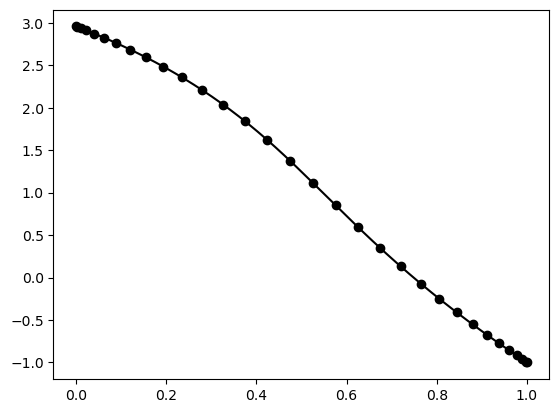

In [5]:
# setup Chebyshev grid and differentiation matrix
N = 32
x = chebyshev_lobatto_grid(0, 1, N)
D = diff_matrix(x)

# setup variable coefficients
A = np.diag( alpha(x) )
B = np.diag( beta(x) )
C = np.diag( gamma(x) )

# setup partition
I = np.eye(N)
e0 = I[:,  0]
eN = I[:, -1]

P = I[:, :-1]
Dh = (I - np.outer(e0, e0)) @ D

# construct the linear system
L = (D @ A @ Dh + B @ Dh + C)

q0 = P.T @ ((D @ A + B) @ e0)
qN = P.T @ (L @ eN)

L = P.T @ L @ P

b = P.T @ f(x) - ua * q0 - ub * qN

# solve
u = P @ solve(L, b) + ub * eN

t = np.linspace(0, 1, 200)
P = interpolation_matrix(x, t)

plt.plot(t, P @ u, '-k')
plt.plot(x, u, 'ok')
plt.show()

## A Nonlinear Example

Consider the nonlinear differential equation

$$\frac{d^2 u}{dx^2} + u - u^3 = 0, \qquad x\in[a,b].$$

Subject to boundary conditions
$$u(a) = u_a, \qquad u(b) = u_b.$$

As before, let $x_k$ be the Chebyshev grid on $[a, b]$, $\vec{u}$ be the vector whose entries are $u_k = u(x_k)$. Then we can set up the nonlinear system of equations:

$$ \mathcal{D}^2 \vec{u} + \vec{u} - \vec{u}^3 = \vec{0}.$$

Here, the power on $\vec{u}$ is applied elementwise.
We can enforce the Dirichlet boundary conditions as before using the partition
$$\vec{u} = P\mathbf{u} + u_a \mathbf{e}_0 + u_b \mathbf{e}_N,$$
which yields,
$$P^T\mathcal{D}^2 (P\mathbf{u} + u_a \mathbf{e}_0 + u_b \mathbf{e}_N) + P^T(P\mathbf{u} + u_a \mathbf{e}_0 + u_b \mathbf{e}_N) - P^T(P\mathbf{u}^3 + u_a^3 \mathbf{e}_0 + u_b^3 \mathbf{e}_N) = \vec{0}.$$

Note that $P^T P = I$, and $P^T \mathbf{e}_0 = P^T \mathbf{e}_N = \vec{0}$, so
$$P^T \mathcal{D}^2 P \mathbf{u} + u_a P^T\mathcal{D}^2\mathbf{e}_0 + u_b P^T\mathcal{D}^2\mathbf{e}_N + \mathbf{u} - \mathbf{u}^3 = \mathbf{0}.$$

Define $\mathbf{L} = P^T \mathcal{D}^2 P$, $\mathbf{b} = u_a P^T \mathcal{D}^2 \mathbf{e}_0 + u_b P^T \mathcal{D}^2 \mathbf{e}_N$, then
$$\mathbf{L} \mathbf{u} + \mathbf{u} - \mathbf{u}^3 + \mathbf{b} = \mathbf{0}.$$

### Solving the Nonlinear System
Here we present a very simple algorithm for estimating the solution to this nonlinear system. Essentially, we start with some initial estimate $\mathbf{u}^{(0)}$ and we successively apply corrections to the solution by solving a related linear system. 
From the current guess $\mathbf{u}^{(n)}$ the residual of the nonlinear system is:
$$\mathbf{r}^{(n)} := \mathbf{L} \mathbf{u}^{(n)} + \mathbf{u}^{(n)} - (\mathbf{u}^{(n)})^3 + \mathbf{b}.$$
We would like $\mathbf{u}^{(n+1)}$ to exactly solve the nonlinear system, that is, we want $\mathbf{r}^{(n+1)} = \mathbf{0}.$ We also assume that $\mathbf{u}^{(n+1)} - \mathbf{u}^{(n)} = \Delta \mathbf{u}^{(n+1)}$ is small. Plug in $\mathbf{u}^{(n)} + \Delta \mathbf{u}^{(n+1)}$ for $\mathbf{u}^{(n+1)}$ in for the equation for $\mathbf{r}^{(n+1)} = \mathbf{0}$:
$$\mathbf{L} \left(\mathbf{u}^{(n)} + \Delta \mathbf{u}^{(n+1)}\right) + \left(\mathbf{u}^{(n)} + \Delta \mathbf{u}^{(n+1)}\right) - (\mathbf{u}^{(n)} + \Delta \mathbf{u}^{(n+1)})^3 + \mathbf{b} = \mathbf{0}.$$
Next, we note that
$$(z + \Delta z)^3 = z^3 + 3 z^2 \Delta z + 3 z \Delta z^2 + \Delta z^3 \approx z^3 + 3z^2 \Delta z$$
for small $\Delta z$. So we approximate
$$\mathbf{L} \left(\mathbf{u}^{(n)} + \Delta \mathbf{u}^{(n+1)}\right) + \left(\mathbf{u}^{(n)} + \Delta \mathbf{u}^{(n+1)}\right) - (\mathbf{u}^{(n)})^3 - 3 (\mathbf{u}^{(n)})^2 \Delta \mathbf{u}^{(n+1)} + \mathbf{b} = \mathbf{0}.$$
Rearanging for $\Delta \mathbf{u}^{(n+1)}$ produces
$$\left(\mathbf{L} + I - 3\mathrm{diag}(\mathbf{u}^{(n)})^2 \right) \Delta \mathbf{u}^{(n+1)} = -\mathbf{L} \mathbf{u}^{(n)} - \mathbf{u}^{(n)} + (\mathbf{u}^{(n)})^3 - \mathbf{b} = -\mathbf{r}^{(n)}.$$
This yields a _linear_ system for $\Delta \mathbf{u}^{(n+1)}$ which we can solve. After repeating this procedure several times, we hope that $\mathbf{u}^{(n)}$ converges to the solution of the linear system. This method is known as [Newton's method](https://en.wikipedia.org/wiki/Newton%27s_method) and generally converges quite quickly. That being said, it is not guaranteed to converge for all problems. More robust (and more efficient) algorithms exist for solving nonlinear systems, but these are not presented here. Nevertheless, very robust and efficient algorithms for solving nonlinear systems are already implemented in [Scipy's `root`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.root.html#scipy.optimize.root) which we will also use as comparison.

Like Newton's method, `root` requires us to provide a function `r`  and an initial estimate of our solution `u0`. Then, `root` attempts to find `u` such that `r(u) == 0`. In our example,

$$ r(\mathbf{u}) = \mathbf{L} \mathbf{u} + \mathbf{u} - \mathbf{u}^3 + \mathbf{b}.$$

### Initial Estimates
How about an initial estimate $\mathbf{u}^{(0)}$? If we knew more about the problem, for example, if we had an asymptotic approximation, we might be able to construct a good initial estimate. Here, let's just take the simplest function which satisfies the boundary conditions, that is, the line:
$$y(x) = u_a + \frac{u_b - u_a}{b - a}(x - a).$$

In [6]:
from scipy.optimize import root

In [7]:
a = 0
b = 1
ua = 1
ub = 10

y = lambda x: ua + (ub - ua)/(b - a) * (x - a)

In [8]:
# set up grid and differentiation matrix
N = 32
x = chebyshev_lobatto_grid(a, b, N)
D = diff_matrix(x)

D2 = D @ D

# partition
I = np.eye(N)
e0 = I[:,  0]
eN = I[:, -1]
P = I[:, 1:-1]

q0 = P.T @ (D2 @ e0)
qN = P.T @ (D2 @ eN)
L = P.T @ D2 @ P

q = ua * q0 + ub * qN

r = lambda z: L @ z + q + z - z**3

u0 = P.T @ y(x)

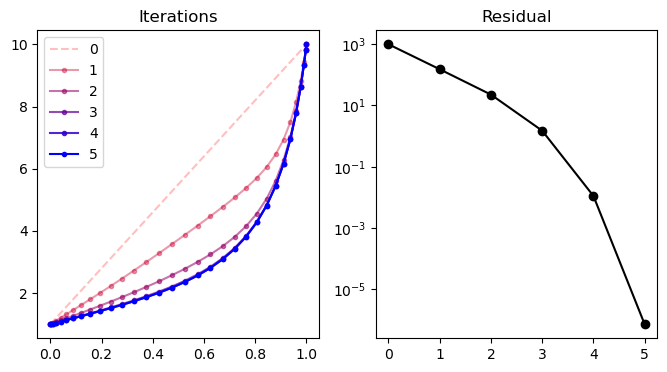

In [9]:

## Newton's Method
num_iterations = 5

c0 = np.array((1, 0, 0, 0.25)) # colors for plotting
c1 = np.array((0, 0, 1, 1))

u = u0.copy()
rs = [np.max(np.abs(r(u))), ]

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(x, P @ u + ua * e0 + ub * eN, '--', c=c0, label=0)
for k in range(1,num_iterations+1):
  du = solve(L + np.eye(N-2) - 3 * np.diag(u**2), -r(u))
  u += du
  
  rs.append(np.max(np.abs(r(u))))
  
  color = (k * c1 + (num_iterations - k) * c0) / num_iterations
  ax[0].plot(x, P @ u + ua * e0 + ub * eN, '.-', c=color, label=k)

ax[0].set_title("Iterations")
ax[0].legend()
ax[1].semilogy(rs, 'o-k')
ax[1].set_title("Residual")
plt.show()

Maximum residual in initial estimate ~ 9.83e+02
Maximum residual in solution produced by `root` ~ 6.42e-06


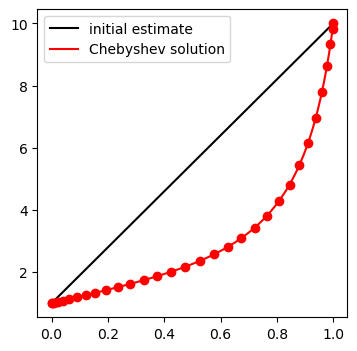

In [10]:
print(f"Maximum residual in initial estimate ~ {np.max(np.abs(r(u0))):.2e}")

sol = root(r, u0)

u = P @ sol.x + ua * e0 + ub * eN

print(f"Maximum residual in solution produced by `root` ~ {np.max(np.abs(r(sol.x))):.2e}")

t = np.linspace(a, b, 200)
V = interpolation_matrix(x, t)

fig, ax = plt.subplots(1, 1, figsize=(4,4))
ax.plot(t, y(t), '-k', label='initial estimate')
ax.plot(t, V @ u, '-r', label='Chebyshev solution')
ax.plot(x, u, 'or')
ax.legend()
plt.show()